## Imports and settings

In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17786582023492265655
]


______________________________________-
## Load datasets

In [131]:
train, xval, test = src.load_datasets("gan")

Training data: (6000, 4, 64, 64, 3)
Validation data: (2000, 4, 64, 64, 3)
Test data: (2000, 4, 64, 64, 3)


In [ ]:
%matplotlib notebook
#visualise channels
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(9,9))
for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,      # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
line1 = ax1.imshow(train[0,0,:,:,0]) # start from index 0 which means 0:50:00
line2 = ax2.imshow(train[0,1,:,:,0]) # start from index 1 which means 1:00:00
line3 = ax3.imshow(train[0,2,:,:,0])
line4 = ax4.imshow(train[0,3,:,:,0])

line = [line1, line2, line3, line4]

def run(i):
    line[0].set_data(train[i,0,:,:,0])
    line[1].set_data(train[i,1,:,:,0])
    line[2].set_data(train[i,2,:,:,0])
    line[3].set_data(train[i,3,:,:,0])
    fig.suptitle(f"Index in array: {i}")
    return line

ani = FuncAnimation(fig, run, blit=True, interval=200, frames=100,
    repeat=False)
plt.show()

<IPython.core.display.Javascript object>


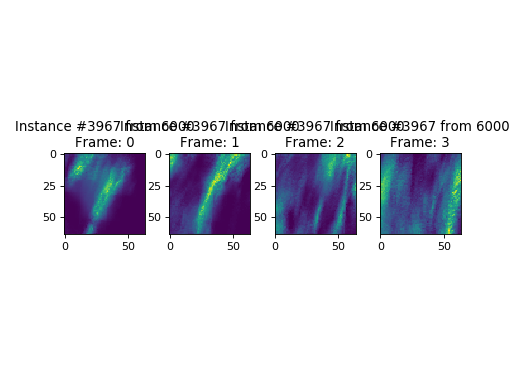

In [169]:
src.visualise_data(train)

## Generator

U-net

In [81]:
#model2=keras.Sequential()
def unet():
    init       = keras.layers.Input(shape=(64,64,1))
    ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
    Lr1        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown1)
    #64
    ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
    Lr2        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown2)
    #32
    ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
    Lr3        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown3)
    #16
    ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
    Lr4        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown4)
    #8
    ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
    Lr5        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown5)
    #4

    UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
    #8
    merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
    Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
    Lr6     = keras.layers.LeakyReLU(alpha=0.1)(Conv1)
    #8
    UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
    #16
    merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
    Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
    Lr7     = keras.layers.LeakyReLU(alpha=0.1)(Conv2)
    #16
    UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

    #32
    Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
    Lr8     = keras.layers.LeakyReLU(alpha=0.1)(Conv3)

    UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
    #64
    Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp4)
    Lr9     = keras.layers.LeakyReLU(alpha=0.1)(Conv4)
    
    Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'tanh')(Lr9)
    
    return keras.models.Model(inputs=init, outputs=Conv5)

In [82]:
unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 8)    40          input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 64, 64, 8)    0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 16)   528         leaky_re_lu_10[0][0]             
__________________________________________________________________________________________________
leaky_re_l

## Discriminator

In [208]:
def spatial_discriminator():
    dropout = 0.5
    #condition is the frame t (the original frame) in both cases
    condition = keras.layers.Input(shape=(64,64,1))
    #other is the generated prediction of frame t+1 or the ground truth frame t+1
    other = keras.layers.Input(shape=(64,64,1))
    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = keras.layers.Concatenate(axis=-1)([condition, other])
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(combined_imgs)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=[condition, other], outputs=sig1)

In [209]:
spatial_discriminator().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 64, 64, 2)    0           input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 4)    132         concatenate_15[0][0]             
__________

In [204]:
def temporal_discriminator():
    dropout = 0.5
    #condition is the frame t (the original frame) in both cases
    advected = keras.layers.Input(shape=(64,64,1))
    #other is the generated prediction of frame t+1 or the ground truth frame t+1
    other = keras.layers.Input(shape=(64,64,1))
    # Concatenate image and conditioning image by channels to produce input
    combined_imgs = keras.layers.Concatenate(axis=-1)([advected, other])
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(combined_imgs)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=[advected, other], outputs=sig1)

In [205]:
temporal_discriminator().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 64, 64, 2)    0           input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 32, 32, 4)    132         concatenate_13[0][0]             
__________

In [198]:
def advect(image): # (64,64,3)
    """
    Applies the physical advection (material derivative) on a density (rain) frame.
    See: https://en.wikipedia.org/wiki/Advection
    in short: r(t+1)=r(t)-vx(t)*drdx(t)-vy(t)*drdy(t)
    :param image: one image with 3 channels: the advected material (rain desity) and the flow field (wind) x and y components. 
    """
    f = 10
    #pad image
    padded = np.pad(image,(0,1),'edge')[:,:,:-1]
    #set nans to 0
    padded[np.isnan(padded)] = 0
    #create array for advected frame
    advected = np.empty_like(image)
    #advect (nans will be treated as 0s)
    advected[:,:,0] = image[:,:,0] - image[:,:,1]*(padded[1:,:,0] - padded[:-1,:,0])[:,:-1] - image[:,:,2]*(padded[:,1:,0] - padded[:,:-1,0])[:-1]
    #renormalize (saturate)
    advected[:,:,0][advected[:,:,0] < 0] = 0
    advected[:,:,0][advected[:,:,0] > 1] = 1   
    #other channels stay the same
    advected[:,:,1:] = image[:,:,1:]
    return advected

In [120]:
s = np.pad(np.eye(3)*np.nan,(0,1),'edge')
s[np.isnan(s)] = 1
s

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [171]:
a,b,c,d,e,f = src.split_datasets(train, xval, test, past_frames=1, future_frames=1)

Shape of training data:  (6000, 64, 64, 3) 
Shape of training truth:  (6000, 64, 64, 3) 
Shape of validation data:  (2000, 64, 64, 3) 
Shape of validation truth:  (2000, 64, 64, 3) 
Shape of test data:  (2000, 64, 64, 3) 
Shape of test truth:  (2000, 64, 64, 3)


In [199]:
advected = np.array([advect(sample) for sample in a])
advected.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


(6000, 64, 64, 3)

<IPython.core.display.Javascript object>


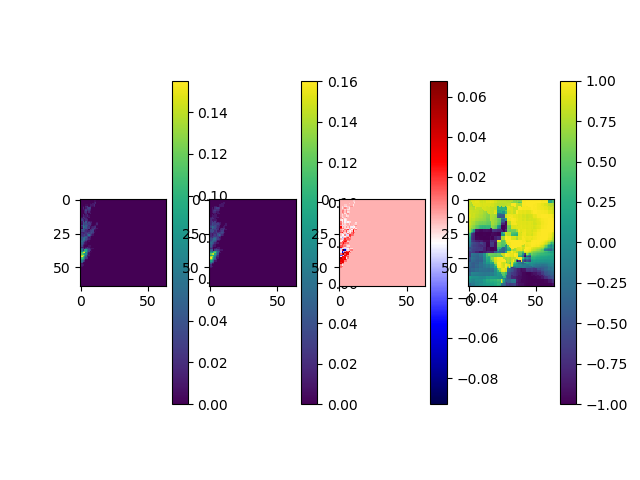

In [200]:
%matplotlib notebook
i= 65
plt.subplot(1,4,1)
plt.imshow(advected[i,:,:,0])
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(a[i,:,:,0])
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(a[i,:,:,0]- advected[i,:,:,0],cmap="seismic")
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(a[i,:,:,2])
plt.colorbar()

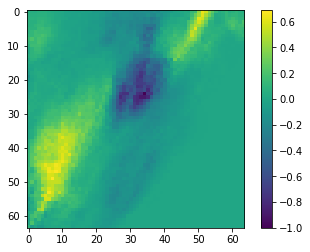

In [36]:
i = 7
plt.imshow(b[i,:,:,0]-a[i,:,:,0])
plt.colorbar()

In [ ]:
#gan cross entropy+l1 useful (pix2pix paper):
#"Although these losses fail to encourage high-
#frequency crispness, in many cases they nonetheless accurately
#capture the low frequencies. For problems where this
#is the case, we do not need an entirely new framework to
#enforce correctness at the low frequencies. L1 will already do."

In [211]:
#modified from source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.metric = [src.relative_error_tensor]

        d_optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        g_optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile spatial discriminator
        self.s_discriminator = self.build_discriminator("s")
        self.s_discriminator.trainable = True
        self.s_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optimizer,
            metrics=["accuracy"])
        
        # Build and compile temporal discriminator
        self.t_discriminator = self.build_discriminator("t")
        self.t_discriminator.trainable = True
        self.t_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optimizer,
            metrics=["accuracy"])
        
        # Build the generator
        self.generator = self.build_generator()
        
        # The generator takes a sequence of frames as input and generates the next image in that sequence
        input_img = keras.layers.Input(shape=self.img_shape)
        cond      = keras.layers.Input(shape=self.img_shape)
        adv       = keras.layers.Input(shape=self.img_shape)
        generated = self.generator(input_img)
        
        # The discriminator takes generated images as input and determines validity
        score_s = self.s_discriminator([cond, generated])
        score_t = self.t_discriminator([adv, generated])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.s_discriminator.trainable = False
        self.t_discriminator.trainable = False
        self.combined = keras.models.Model(input_img, outputs=[score_s, score_t])
        self.combined.compile(loss='mae', optimizer=g_optimizer)


    def build_generator(self,network="U-net"):  
        generator = keras.Sequential()
        if network in ["Unet", "U-net", "unet", "u-net"]:
            return unet()

    def build_discriminator(self, which="s"):
        if which == "s":
            return spatial_discriminator()
        elif which == "t":
            return temporal_discriminator()

    def train(self, epochs, g_epochs=1, d_epochs=1, dataset="5min", batch_size=128, dual=False):

        # Load the dataset
        train, xval, test = src.load_datasets(dataset=dataset)
        
        # split the dataset
        past_frames = [2 if dual else 1]  # at least 2 frames needed into the temporal discriminator
        future_frames = 1
        gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train, xval, test, past_frames, future_frames)
        
        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        #store losses
        log = {"g_loss":[],
               "d_loss":[],
               "g_metric":[],
               "d_metric":[]}
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminators
            # ---------------------

            idx = np.random.randint(0, gan_truth.shape[0], batch_size)
            real_imgs = gan_truth[idx]
            training_batch = gan_train[idx]
            # Generate a batch of new images
            generated_imgs = self.generator.predict(training_batch)

            # Train the first discriminator
            #inputs: [frame t, generated frame t+1 (from frame t)] & [frame t, ground truth of frame t (frame t+1)]
            #batches are unmixed
            for ks in range(d_epochs):
                ds_loss_real = self.discriminator.train_on_batch([training_batch, real_imgs], real)
                ds_loss_fake = self.discriminator.train_on_batch([training_batch, generated_imgs], fake)
                ds_loss = 0.5 * np.add(ds_loss_real, ds_loss_fake)
                print(f"    {ks} [Ds loss: {ds_loss[0]}, acc.: {100*ds_loss[1]}]")
            d_loss = ds_loss
                
            if dual:
                # Train the second discriminator
                #inputs: [advected generated frame t (from frame t-1), generated frame t+1 (from frame t)] &
                #        [advected ground truth of frame t-1 (advected frame t), ground truth frame t (frame t+1)]
                #batches are unmixed
                for kt in range(d_epochs):
                    assert real_imgs.shape[1] > 1
                    advected_gen = np.array([advect(sample) for sample in generated_imgs])
                    advected_truth = np.array([advect(sample) for sample in real_imgs])

                    dt_loss_real = self.discriminator.train_on_batch([advected_truth, real_imgs], real)
                    dt_loss_fake = self.discriminator.train_on_batch([advected_gen, generated_imgs], fake)
                    dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
                    print(f"    {kt} [Dt loss: {dt_loss[0]}, acc.: {100*dt_loss[1]}]")
                d_loss = ds_loss + dt_loss
            
            # ---------------------
            #  Train Generator
            # ---------------------

            idx2 = np.random.randint(0, gan_train.shape[0], batch_size)
            training_batch = gan_train[idx2]
            training_truth = gan_truth[idx2]

            # Train the generator (to have the discriminator label samples as real)
            for kg in range(g_epochs):
                g_loss = self.combined.train_on_batch(training_batch, real)

            # Plot the progress
            log["g_loss"].append(g_loss)
            log["d_loss"].append(d_loss[0])
            #log["g_metric"].append(g_loss[1])
            log["d_metric"].append(d_loss[1])
            print(f"\033[1m {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]\033[0m"+
                  f"\033[1m[G loss: {g_loss}]\033[0m")#, rel. err.: {g_loss[1]}] \033[0m")

            # If at save interval => save generated image samples
            if epoch in [int(x) for x in np.linspace(0.1,1,10)*epochs]:
                self.sample_images(epoch, gan_test, gan_test_truth)
        return log

    def sample_images(self, epoch, gan_test, gan_test_truth):
        n = 5
        test_batch = gan_test[:n]
        test_truth = gan_test_truth[:n]
        gen_imgs = self.generator.predict(test_batch)

        fig, axs = plt.subplots(n, 3, figsize=(16, 16))
        for i in range(n):
                axs[i,0].imshow(test_batch[i, :,:,0])
                axs[i,0].axis('off')
                axs[i,0].set_title("Frame t")
                axs[i,1].imshow(test_truth[i, :,:,0])
                axs[i,1].axis('off')
                axs[i,1].set_title("Frame t+1")
                axs[i,2].imshow(gen_imgs[i, :,:,0])
                axs[i,2].axis('off')
                axs[i,2].set_title("Prediction t+1")
        fig.savefig("Plots/epoch %d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    log = gan.train(epochs=10, d_epochs=5, batch_size=64)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_42:0", shape=(?, 64, 64, 1), dtype=float32) at layer "input_42". The following previous layers were accessed without issue: ['input_40']

In [ ]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(log["g_loss"],label="Generator loss")
ax.plot(log["d_loss"],label="Discriminator loss")
ax.grid()
ax.legend(loc="best")

ax2.plot(log["g_metric"],label="Generator metric")
ax2.plot(log["d_metric"],label="Discriminator metric")
ax2.grid()
ax2.legend(loc="center right")